In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [3]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [4]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value


r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [5]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((num_frames, num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.5
d0 = 2.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [6]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

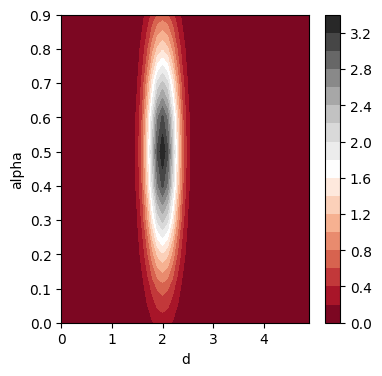

In [7]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, 50)

In [8]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [9]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (10, 50, 100, 500)
shape of Z : torch.Size([10, 50, 100, 500])


In [10]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((num_frames, len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = torch.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals)
            u_pred[i, j] = torch.trapz(integrand, alpha_vals)

    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True) + 1e-9)
    
    # norm = (torch.trapz(u_pred, k_vals, dim=1))

    # u_pred = u_pred / norm[:, None]


    return u_pred    

In [11]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]
    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))

    return loss

In [12]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, 50)
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

epoch 1 / 500 : loss = 102851.84375
epoch 2 / 500 : loss = 102759.0546875
epoch 3 / 500 : loss = 102690.3984375
epoch 4 / 500 : loss = 102636.1484375


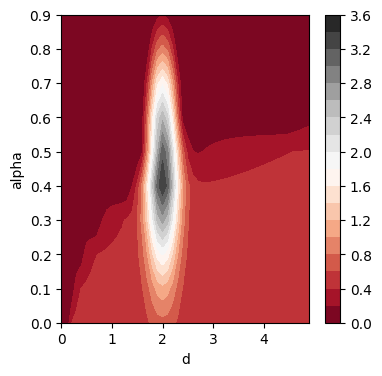

epoch 5 / 500 : loss = 102592.453125
epoch 6 / 500 : loss = 102555.296875
epoch 7 / 500 : loss = 102523.40625
epoch 8 / 500 : loss = 102496.546875
epoch 9 / 500 : loss = 102472.859375


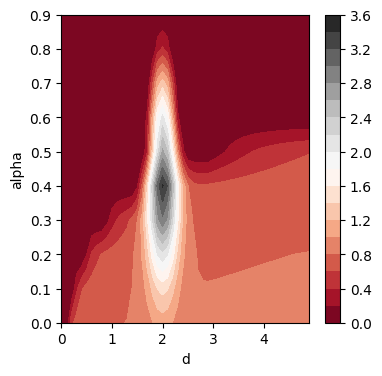

epoch 10 / 500 : loss = 102450.96875
epoch 11 / 500 : loss = 102431.2734375
epoch 12 / 500 : loss = 102412.8671875
epoch 13 / 500 : loss = 102395.2109375
epoch 14 / 500 : loss = 102379.2734375


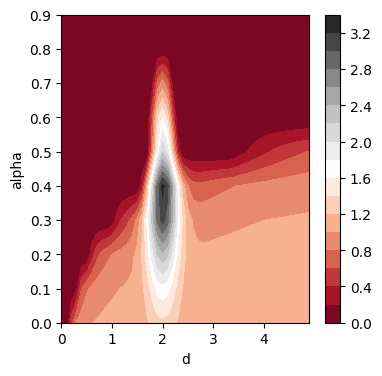

epoch 15 / 500 : loss = 102364.4765625
epoch 16 / 500 : loss = 102350.5546875
epoch 17 / 500 : loss = 102337.25
epoch 18 / 500 : loss = 102324.4921875
epoch 19 / 500 : loss = 102312.3125


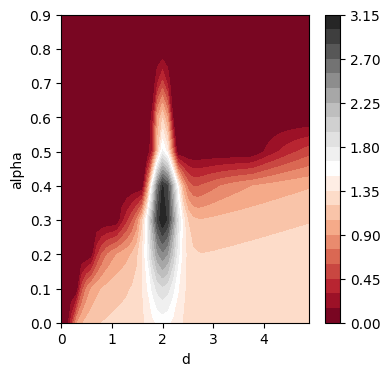

epoch 20 / 500 : loss = 102300.5078125
epoch 21 / 500 : loss = 102289.5390625
epoch 22 / 500 : loss = 102280.15625
epoch 23 / 500 : loss = 102271.328125
epoch 24 / 500 : loss = 102263.75


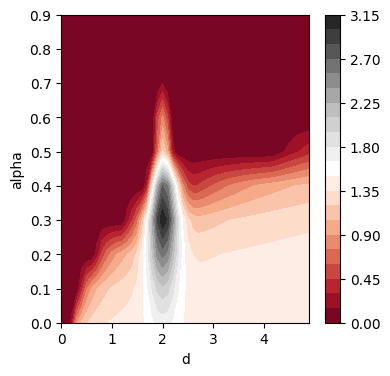

epoch 25 / 500 : loss = 102256.734375
epoch 26 / 500 : loss = 102250.109375
epoch 27 / 500 : loss = 102243.8671875
epoch 28 / 500 : loss = 102238.015625
epoch 29 / 500 : loss = 102232.875


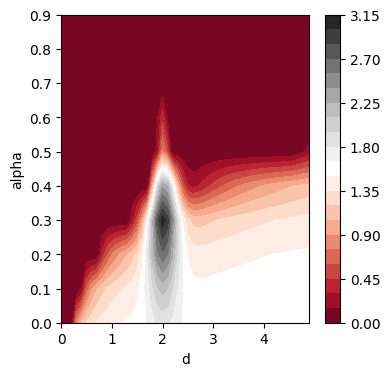

epoch 30 / 500 : loss = 102227.8203125
epoch 31 / 500 : loss = 102223.3828125
epoch 32 / 500 : loss = 102219.4609375
epoch 33 / 500 : loss = 102215.7265625
epoch 34 / 500 : loss = 102212.28125


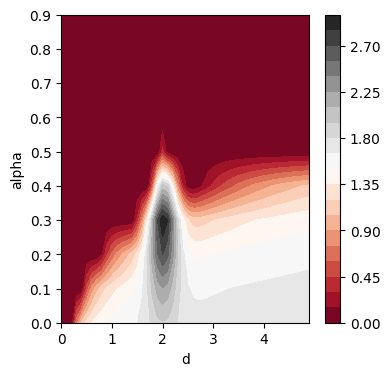

epoch 35 / 500 : loss = 102209.078125
epoch 36 / 500 : loss = 102205.8046875
epoch 37 / 500 : loss = 102202.53125
epoch 38 / 500 : loss = 102199.25
epoch 39 / 500 : loss = 102195.953125


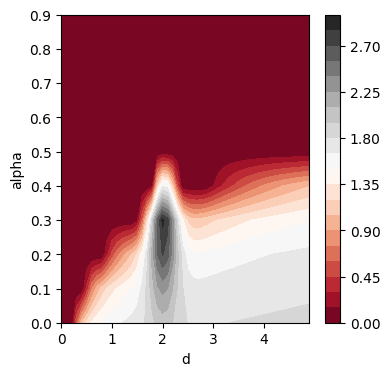

epoch 40 / 500 : loss = 102192.65625
epoch 41 / 500 : loss = 102189.2734375
epoch 42 / 500 : loss = 102185.890625
epoch 43 / 500 : loss = 102182.4453125
epoch 44 / 500 : loss = 102178.8984375


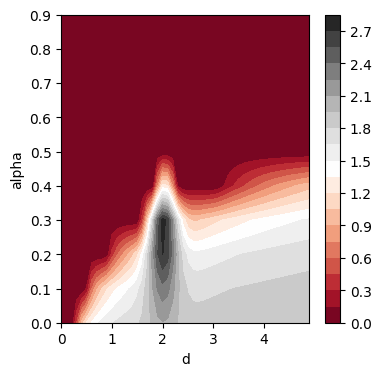

epoch 45 / 500 : loss = 102175.34375
epoch 46 / 500 : loss = 102171.609375
epoch 47 / 500 : loss = 102167.859375
epoch 48 / 500 : loss = 102163.90625
epoch 49 / 500 : loss = 102159.765625


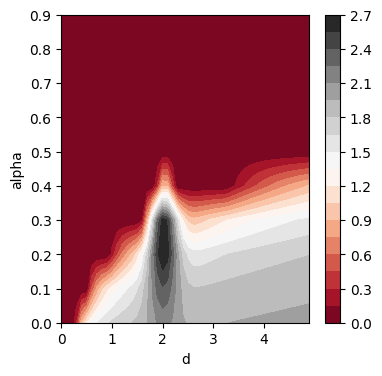

epoch 50 / 500 : loss = 102155.5546875
epoch 51 / 500 : loss = 102151.15625
epoch 52 / 500 : loss = 102146.515625
epoch 53 / 500 : loss = 102141.5859375
epoch 54 / 500 : loss = 102136.546875


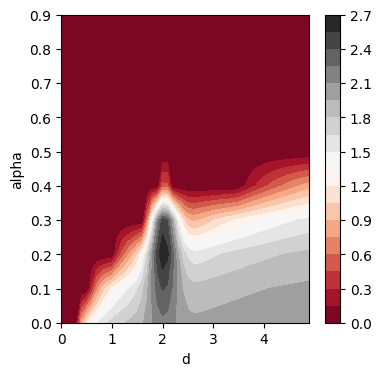

epoch 55 / 500 : loss = 102131.171875
epoch 56 / 500 : loss = 102125.3828125
epoch 57 / 500 : loss = 102119.46875
epoch 58 / 500 : loss = 102113.8203125
epoch 59 / 500 : loss = 102108.2578125


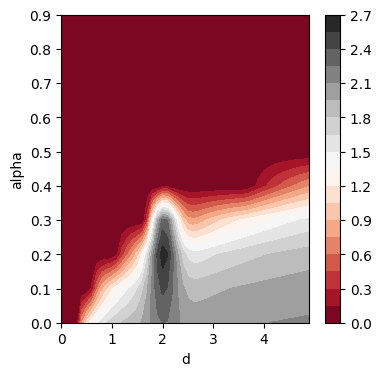

epoch 60 / 500 : loss = 102103.0078125
epoch 61 / 500 : loss = 102097.6953125
epoch 62 / 500 : loss = 102092.8671875
epoch 63 / 500 : loss = 102088.3203125
epoch 64 / 500 : loss = 102084.5


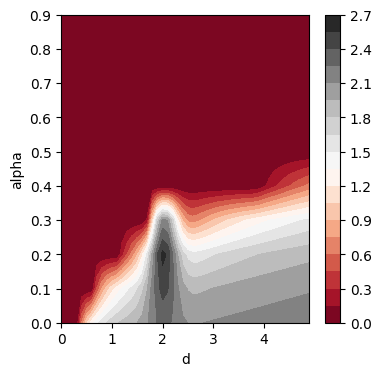

epoch 65 / 500 : loss = 102081.1015625
epoch 66 / 500 : loss = 102078.171875
epoch 67 / 500 : loss = 102075.6015625
epoch 68 / 500 : loss = 102073.4765625
epoch 69 / 500 : loss = 102071.84375


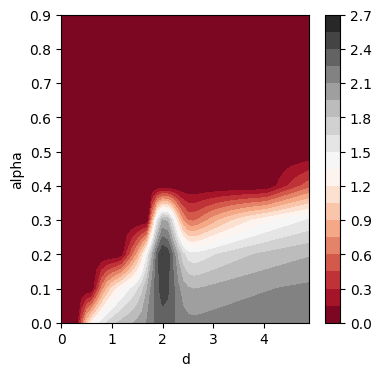

epoch 70 / 500 : loss = 102070.671875
epoch 71 / 500 : loss = 102069.75
epoch 72 / 500 : loss = 102068.8359375
epoch 73 / 500 : loss = 102067.890625
epoch 74 / 500 : loss = 102066.9375


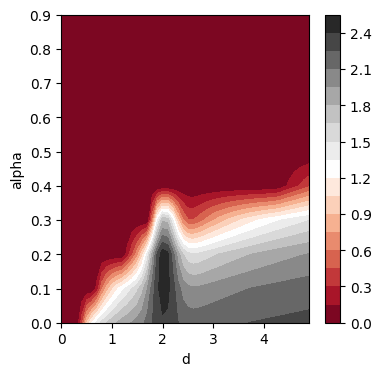

epoch 75 / 500 : loss = 102066.015625
epoch 76 / 500 : loss = 102065.125
epoch 77 / 500 : loss = 102064.234375
epoch 78 / 500 : loss = 102063.3203125
epoch 79 / 500 : loss = 102062.4453125


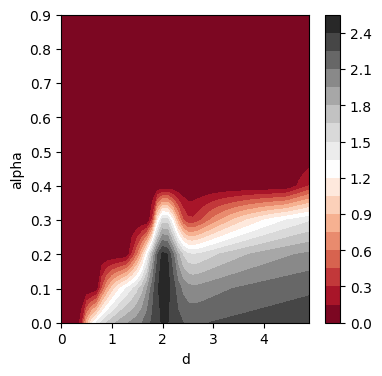

epoch 80 / 500 : loss = 102061.609375
epoch 81 / 500 : loss = 102060.765625
epoch 82 / 500 : loss = 102059.921875
epoch 83 / 500 : loss = 102059.0703125
epoch 84 / 500 : loss = 102058.3125


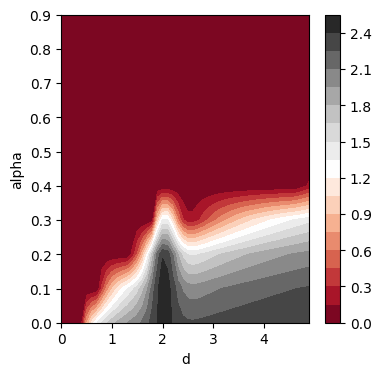

epoch 85 / 500 : loss = 102057.5234375
epoch 86 / 500 : loss = 102056.734375
epoch 87 / 500 : loss = 102055.953125
epoch 88 / 500 : loss = 102055.2265625
epoch 89 / 500 : loss = 102054.5


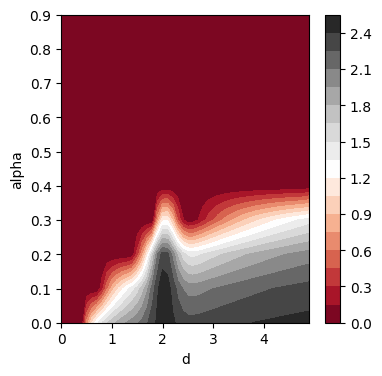

epoch 90 / 500 : loss = 102053.7421875
epoch 91 / 500 : loss = 102053.0234375
epoch 92 / 500 : loss = 102052.359375
epoch 93 / 500 : loss = 102051.6796875
epoch 94 / 500 : loss = 102050.984375


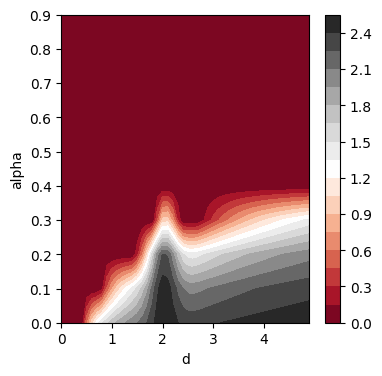

epoch 95 / 500 : loss = 102050.3203125
epoch 96 / 500 : loss = 102049.7109375
epoch 97 / 500 : loss = 102049.0625
epoch 98 / 500 : loss = 102048.421875
epoch 99 / 500 : loss = 102047.8046875


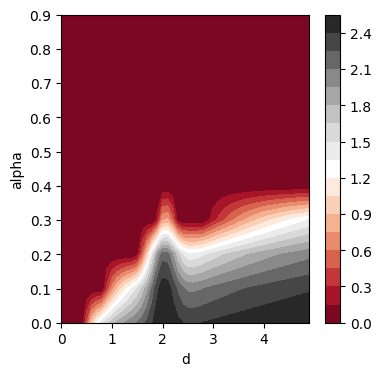

epoch 100 / 500 : loss = 102047.21875
epoch 101 / 500 : loss = 102046.6484375
epoch 102 / 500 : loss = 102046.046875
epoch 103 / 500 : loss = 102045.4609375
epoch 104 / 500 : loss = 102044.921875


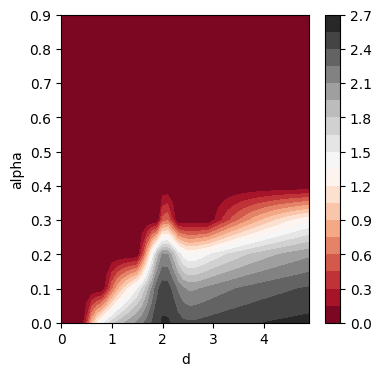

epoch 105 / 500 : loss = 102044.3828125
epoch 106 / 500 : loss = 102043.8046875
epoch 107 / 500 : loss = 102043.265625
epoch 108 / 500 : loss = 102042.7578125
epoch 109 / 500 : loss = 102042.2578125


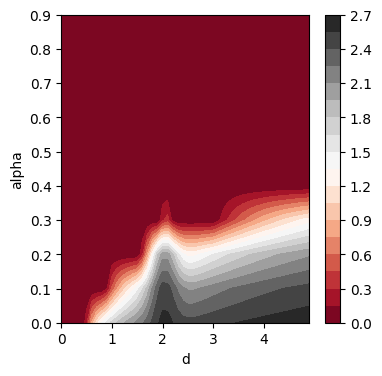

epoch 110 / 500 : loss = 102041.734375
epoch 111 / 500 : loss = 102041.21875
epoch 112 / 500 : loss = 102040.7109375
epoch 113 / 500 : loss = 102040.2421875
epoch 114 / 500 : loss = 102039.7890625


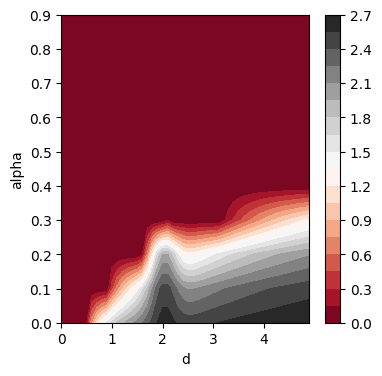

epoch 115 / 500 : loss = 102039.2890625
epoch 116 / 500 : loss = 102038.8046875
epoch 117 / 500 : loss = 102038.3125
epoch 118 / 500 : loss = 102037.859375
epoch 119 / 500 : loss = 102037.421875


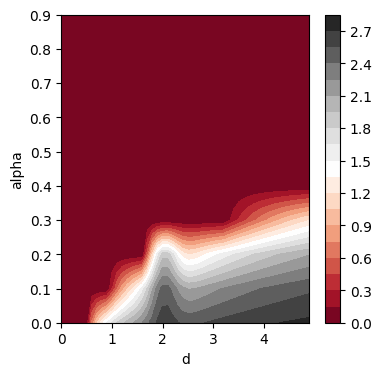

epoch 120 / 500 : loss = 102036.9609375
epoch 121 / 500 : loss = 102036.5234375
epoch 122 / 500 : loss = 102036.0546875
epoch 123 / 500 : loss = 102035.6015625
epoch 124 / 500 : loss = 102035.1484375


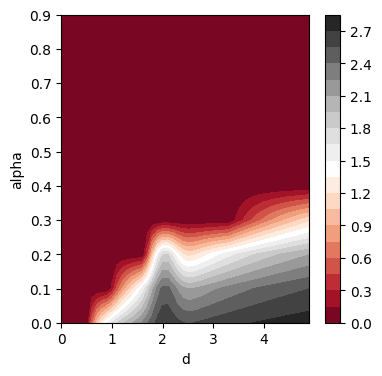

epoch 125 / 500 : loss = 102034.71875
epoch 126 / 500 : loss = 102034.2890625
epoch 127 / 500 : loss = 102033.875
epoch 128 / 500 : loss = 102033.453125
epoch 129 / 500 : loss = 102033.0


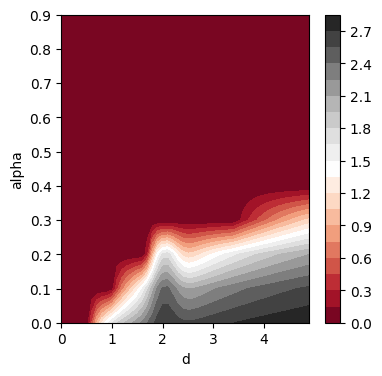

epoch 130 / 500 : loss = 102032.5625
epoch 131 / 500 : loss = 102032.125
epoch 132 / 500 : loss = 102031.7109375
epoch 133 / 500 : loss = 102031.3046875
epoch 134 / 500 : loss = 102030.8984375


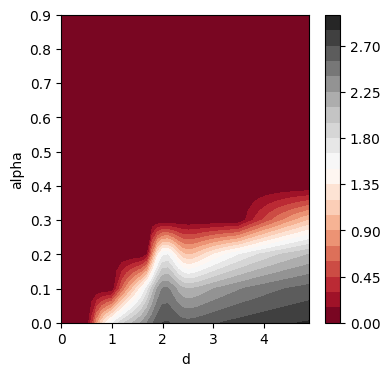

epoch 135 / 500 : loss = 102030.4765625
epoch 136 / 500 : loss = 102030.0703125
epoch 137 / 500 : loss = 102029.640625
epoch 138 / 500 : loss = 102029.1875
epoch 139 / 500 : loss = 102028.7890625


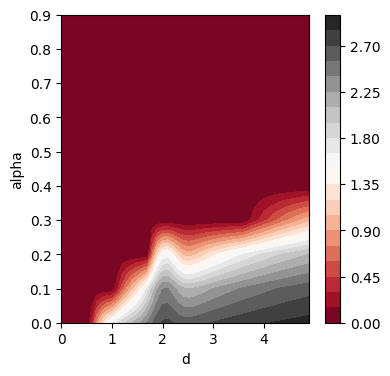

epoch 140 / 500 : loss = 102028.4140625
epoch 141 / 500 : loss = 102028.015625
epoch 142 / 500 : loss = 102027.609375
epoch 143 / 500 : loss = 102027.1953125
epoch 144 / 500 : loss = 102026.7890625


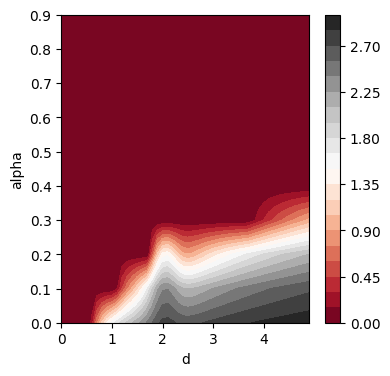

epoch 145 / 500 : loss = 102026.3828125
epoch 146 / 500 : loss = 102026.0234375
epoch 147 / 500 : loss = 102025.65625
epoch 148 / 500 : loss = 102025.28125
epoch 149 / 500 : loss = 102024.890625


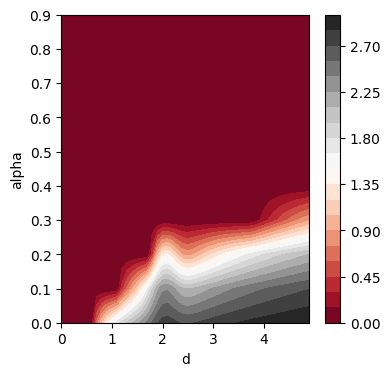

epoch 150 / 500 : loss = 102024.5234375
epoch 151 / 500 : loss = 102024.1953125
epoch 152 / 500 : loss = 102023.84375
epoch 153 / 500 : loss = 102023.5
epoch 154 / 500 : loss = 102023.15625


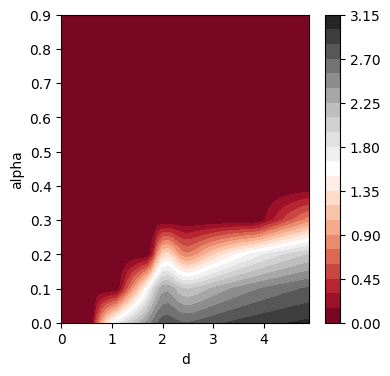

epoch 155 / 500 : loss = 102022.84375
epoch 156 / 500 : loss = 102022.5546875
epoch 157 / 500 : loss = 102022.2421875
epoch 158 / 500 : loss = 102021.9453125
epoch 159 / 500 : loss = 102021.65625


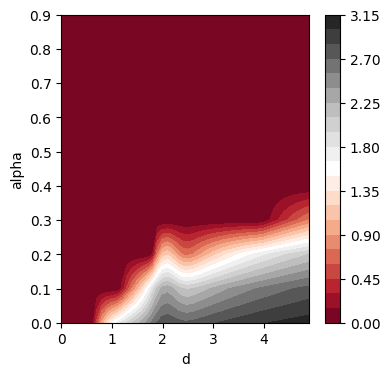

epoch 160 / 500 : loss = 102021.3984375
epoch 161 / 500 : loss = 102021.1015625
epoch 162 / 500 : loss = 102020.8203125
epoch 163 / 500 : loss = 102020.5625
epoch 164 / 500 : loss = 102020.3203125


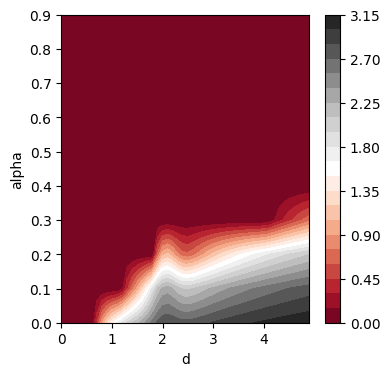

epoch 165 / 500 : loss = 102020.0625
epoch 166 / 500 : loss = 102019.8203125
epoch 167 / 500 : loss = 102019.546875
epoch 168 / 500 : loss = 102019.296875
epoch 169 / 500 : loss = 102019.0546875


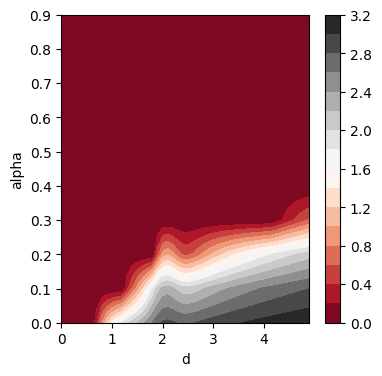

epoch 170 / 500 : loss = 102018.8515625
epoch 171 / 500 : loss = 102018.609375
epoch 172 / 500 : loss = 102018.390625
epoch 173 / 500 : loss = 102018.1484375
epoch 174 / 500 : loss = 102017.921875


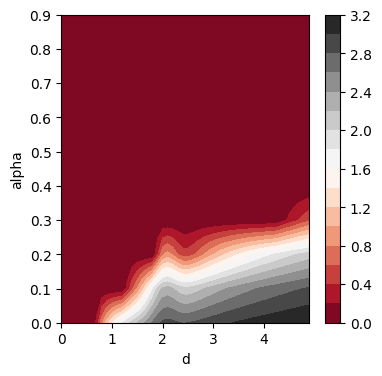

epoch 175 / 500 : loss = 102017.6875
epoch 176 / 500 : loss = 102017.4765625
epoch 177 / 500 : loss = 102017.2734375
epoch 178 / 500 : loss = 102017.078125
epoch 179 / 500 : loss = 102016.859375


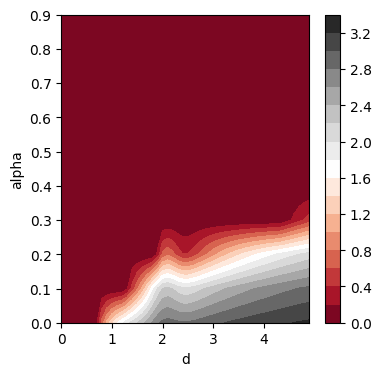

epoch 180 / 500 : loss = 102016.6484375
epoch 181 / 500 : loss = 102016.4140625
epoch 182 / 500 : loss = 102016.1875
epoch 183 / 500 : loss = 102016.0
epoch 184 / 500 : loss = 102015.8046875


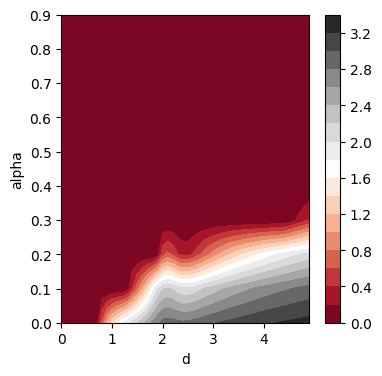

epoch 185 / 500 : loss = 102015.6171875
epoch 186 / 500 : loss = 102015.4375
epoch 187 / 500 : loss = 102015.2421875
epoch 188 / 500 : loss = 102015.0546875
epoch 189 / 500 : loss = 102014.8515625


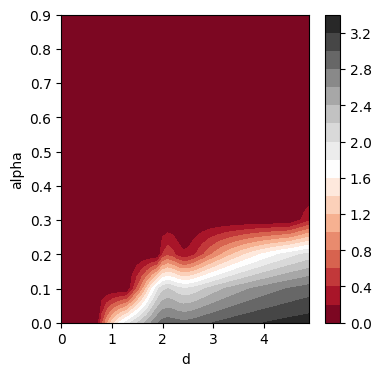

epoch 190 / 500 : loss = 102014.6640625
epoch 191 / 500 : loss = 102014.4296875
epoch 192 / 500 : loss = 102014.2734375
epoch 193 / 500 : loss = 102014.109375
epoch 194 / 500 : loss = 102013.921875


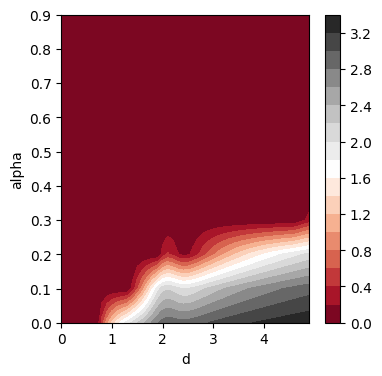

epoch 195 / 500 : loss = 102013.7578125
epoch 196 / 500 : loss = 102013.578125
epoch 197 / 500 : loss = 102013.4140625
epoch 198 / 500 : loss = 102013.234375
epoch 199 / 500 : loss = 102013.0546875


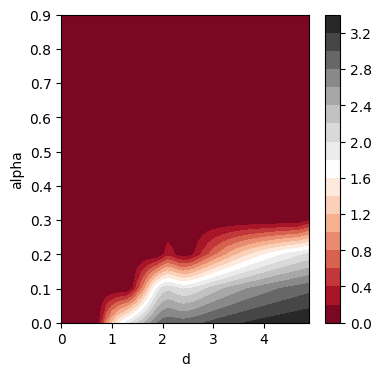

epoch 200 / 500 : loss = 102012.875
epoch 201 / 500 : loss = 102012.7109375
epoch 202 / 500 : loss = 102012.5625
epoch 203 / 500 : loss = 102012.390625
epoch 204 / 500 : loss = 102012.2421875


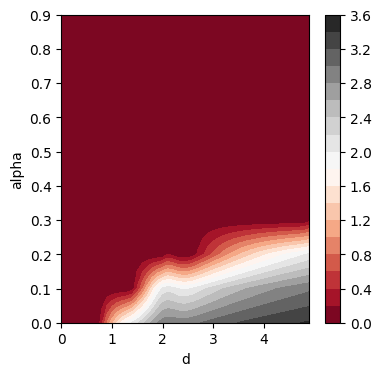

epoch 205 / 500 : loss = 102012.1015625
epoch 206 / 500 : loss = 102011.9453125
epoch 207 / 500 : loss = 102011.765625
epoch 208 / 500 : loss = 102011.609375
epoch 209 / 500 : loss = 102011.4453125


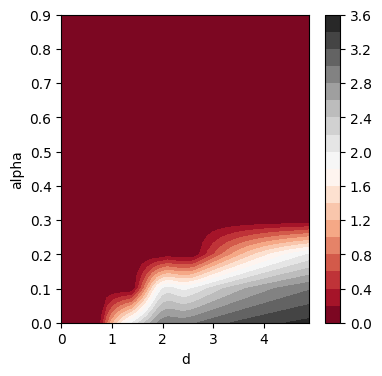

epoch 210 / 500 : loss = 102011.28125
epoch 211 / 500 : loss = 102011.125
epoch 212 / 500 : loss = 102011.0
epoch 213 / 500 : loss = 102010.84375
epoch 214 / 500 : loss = 102010.7109375


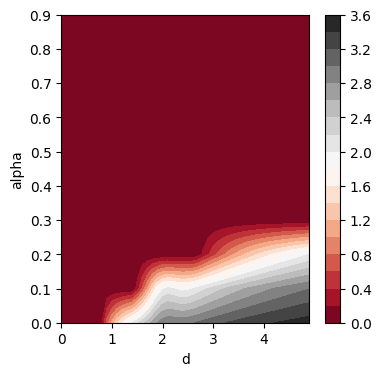

epoch 215 / 500 : loss = 102010.5859375
epoch 216 / 500 : loss = 102010.4296875
epoch 217 / 500 : loss = 102010.2734375
epoch 218 / 500 : loss = 102010.140625
epoch 219 / 500 : loss = 102009.9921875


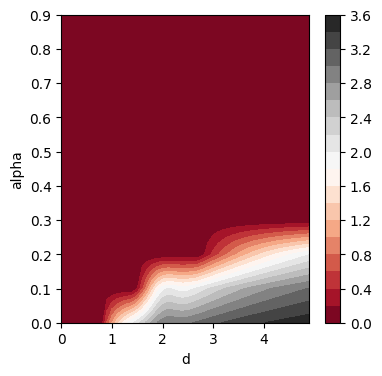

epoch 220 / 500 : loss = 102009.8359375
epoch 221 / 500 : loss = 102009.6875
epoch 222 / 500 : loss = 102009.5625
epoch 223 / 500 : loss = 102009.4375
epoch 224 / 500 : loss = 102009.328125


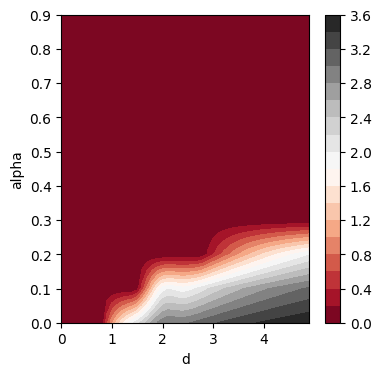

epoch 225 / 500 : loss = 102009.1875
epoch 226 / 500 : loss = 102009.0625
epoch 227 / 500 : loss = 102008.9375
epoch 228 / 500 : loss = 102008.8046875
epoch 229 / 500 : loss = 102008.671875


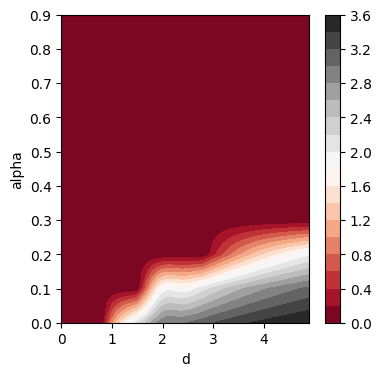

epoch 230 / 500 : loss = 102008.5390625
epoch 231 / 500 : loss = 102008.3984375
epoch 232 / 500 : loss = 102008.265625
epoch 233 / 500 : loss = 102008.15625
epoch 234 / 500 : loss = 102008.0390625


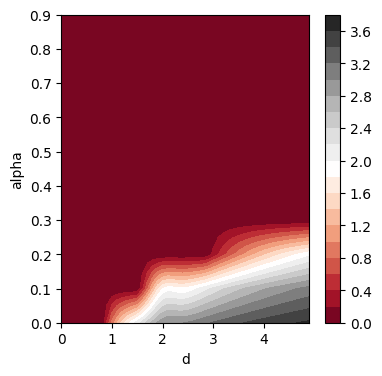

epoch 235 / 500 : loss = 102007.921875
epoch 236 / 500 : loss = 102007.8125
epoch 237 / 500 : loss = 102007.7109375
epoch 238 / 500 : loss = 102007.5859375
epoch 239 / 500 : loss = 102007.4609375


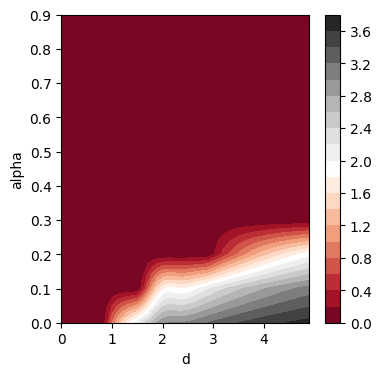

epoch 240 / 500 : loss = 102007.3671875
epoch 241 / 500 : loss = 102007.2578125
epoch 242 / 500 : loss = 102007.125
epoch 243 / 500 : loss = 102007.0
epoch 244 / 500 : loss = 102006.890625


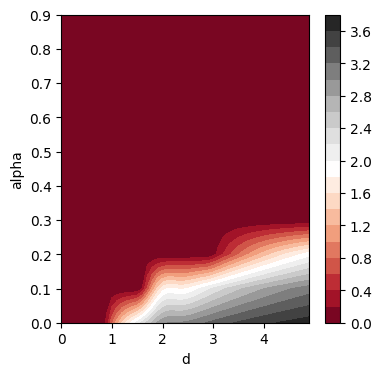

epoch 245 / 500 : loss = 102006.765625
epoch 246 / 500 : loss = 102006.6640625
epoch 247 / 500 : loss = 102006.5546875
epoch 248 / 500 : loss = 102006.453125
epoch 249 / 500 : loss = 102006.3515625


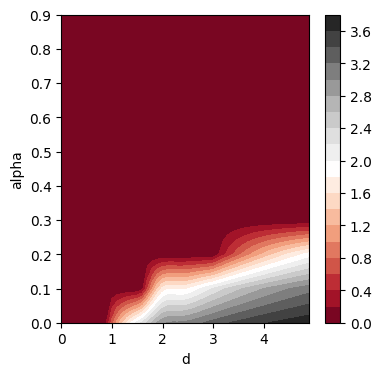

epoch 250 / 500 : loss = 102006.25
epoch 251 / 500 : loss = 102006.125
epoch 252 / 500 : loss = 102006.0546875
epoch 253 / 500 : loss = 102005.9609375
epoch 254 / 500 : loss = 102005.859375


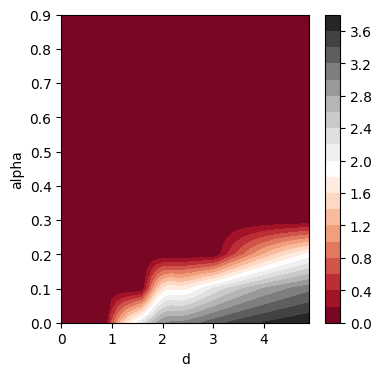

epoch 255 / 500 : loss = 102005.75
epoch 256 / 500 : loss = 102005.6328125
epoch 257 / 500 : loss = 102005.515625
epoch 258 / 500 : loss = 102005.421875
epoch 259 / 500 : loss = 102005.328125


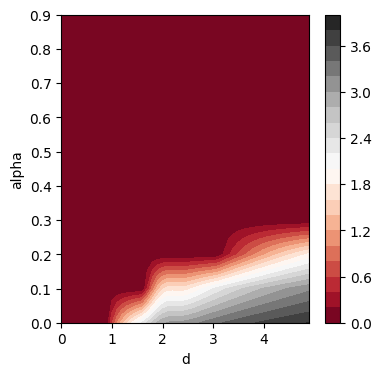

epoch 260 / 500 : loss = 102005.203125
epoch 261 / 500 : loss = 102005.1015625
epoch 262 / 500 : loss = 102005.0390625
epoch 263 / 500 : loss = 102004.9375
epoch 264 / 500 : loss = 102004.8671875


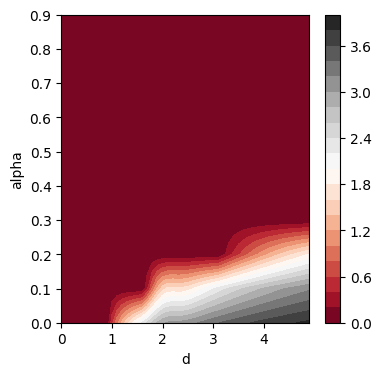

epoch 265 / 500 : loss = 102004.7734375
epoch 266 / 500 : loss = 102004.6796875
epoch 267 / 500 : loss = 102004.59375
epoch 268 / 500 : loss = 102004.5078125
epoch 269 / 500 : loss = 102004.4140625


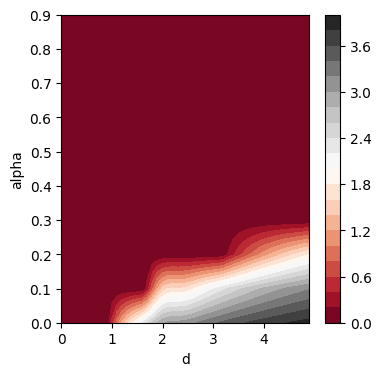

epoch 270 / 500 : loss = 102004.3125
epoch 271 / 500 : loss = 102004.21875
epoch 272 / 500 : loss = 102004.1328125
epoch 273 / 500 : loss = 102004.046875
epoch 274 / 500 : loss = 102003.953125


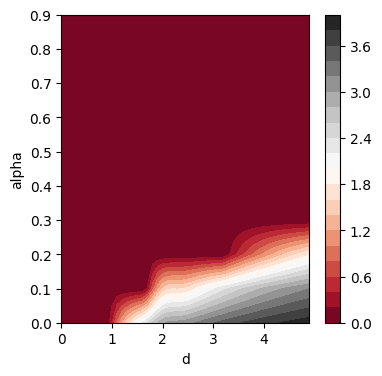

epoch 275 / 500 : loss = 102003.84375
epoch 276 / 500 : loss = 102003.75
epoch 277 / 500 : loss = 102003.6796875
epoch 278 / 500 : loss = 102003.6015625
epoch 279 / 500 : loss = 102003.5390625


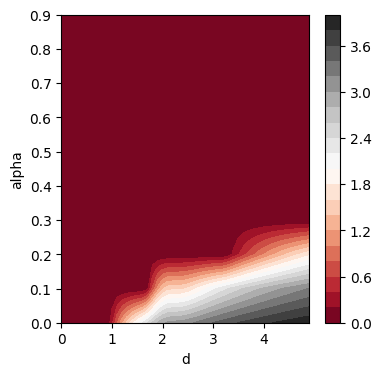

epoch 280 / 500 : loss = 102003.453125
epoch 281 / 500 : loss = 102003.390625
epoch 282 / 500 : loss = 102003.3125
epoch 283 / 500 : loss = 102003.2109375
epoch 284 / 500 : loss = 102003.1484375


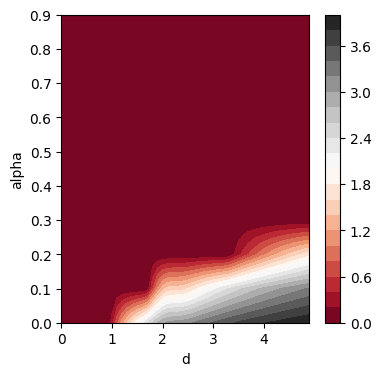

epoch 285 / 500 : loss = 102003.0625
epoch 286 / 500 : loss = 102002.984375
epoch 287 / 500 : loss = 102002.890625
epoch 288 / 500 : loss = 102002.8203125
epoch 289 / 500 : loss = 102002.7265625


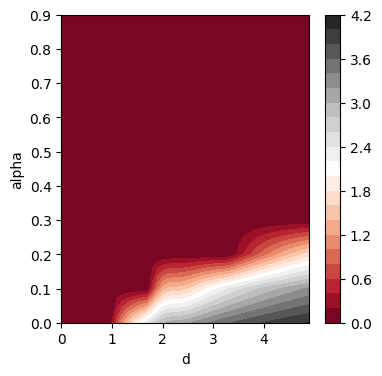

epoch 290 / 500 : loss = 102002.6328125
epoch 291 / 500 : loss = 102002.5625
epoch 292 / 500 : loss = 102002.4609375
epoch 293 / 500 : loss = 102002.390625
epoch 294 / 500 : loss = 102002.3203125


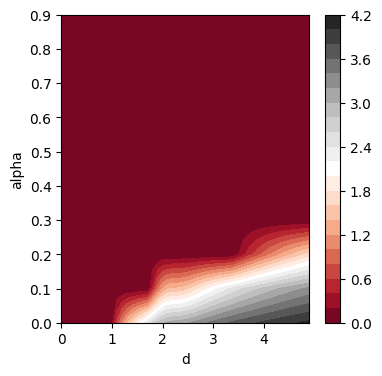

epoch 295 / 500 : loss = 102002.2578125
epoch 296 / 500 : loss = 102002.1796875
epoch 297 / 500 : loss = 102002.109375
epoch 298 / 500 : loss = 102002.046875
epoch 299 / 500 : loss = 102001.984375


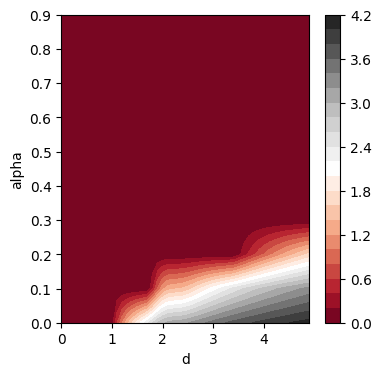

epoch 300 / 500 : loss = 102001.921875
epoch 301 / 500 : loss = 102001.8515625
epoch 302 / 500 : loss = 102001.765625
epoch 303 / 500 : loss = 102001.703125
epoch 304 / 500 : loss = 102001.640625


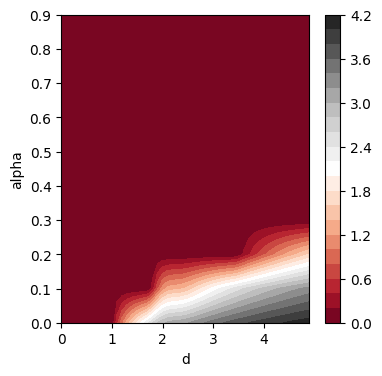

epoch 305 / 500 : loss = 102001.5625
epoch 306 / 500 : loss = 102001.5
epoch 307 / 500 : loss = 102001.4375
epoch 308 / 500 : loss = 102001.3671875
epoch 309 / 500 : loss = 102001.2890625


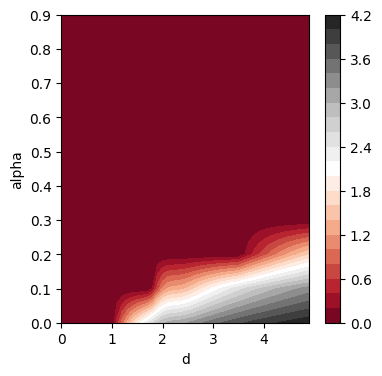

epoch 310 / 500 : loss = 102001.21875
epoch 311 / 500 : loss = 102001.1171875
epoch 312 / 500 : loss = 102001.0546875
epoch 313 / 500 : loss = 102001.0078125
epoch 314 / 500 : loss = 102000.9296875


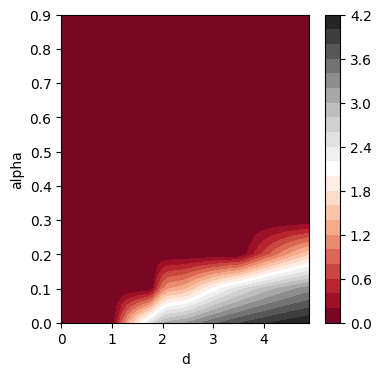

epoch 315 / 500 : loss = 102000.8671875
epoch 316 / 500 : loss = 102000.8046875
epoch 317 / 500 : loss = 102000.75
epoch 318 / 500 : loss = 102000.6953125
epoch 319 / 500 : loss = 102000.6484375


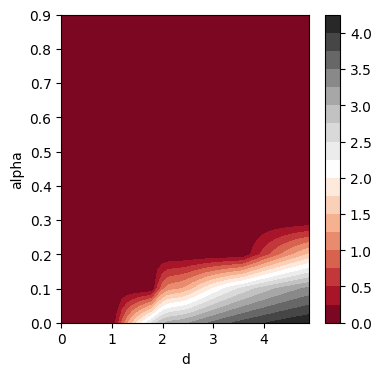

epoch 320 / 500 : loss = 102000.578125
epoch 321 / 500 : loss = 102000.5234375
epoch 322 / 500 : loss = 102000.46875
epoch 323 / 500 : loss = 102000.4140625
epoch 324 / 500 : loss = 102000.34375


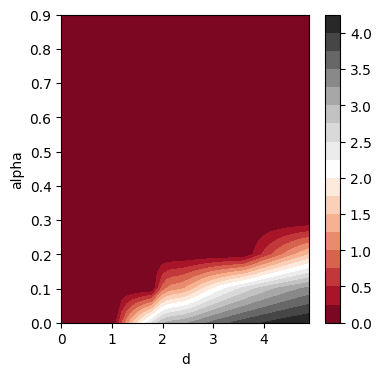

epoch 325 / 500 : loss = 102000.28125
epoch 326 / 500 : loss = 102000.21875
epoch 327 / 500 : loss = 102000.1484375
epoch 328 / 500 : loss = 102000.1015625
epoch 329 / 500 : loss = 102000.0390625


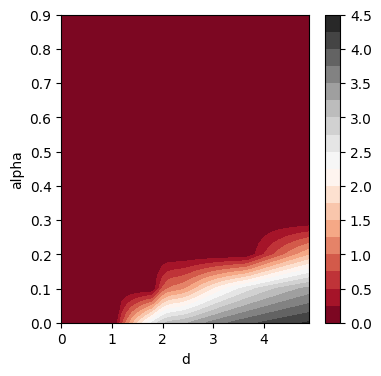

epoch 330 / 500 : loss = 101999.9765625
epoch 331 / 500 : loss = 101999.921875
epoch 332 / 500 : loss = 101999.8515625
epoch 333 / 500 : loss = 101999.78125
epoch 334 / 500 : loss = 101999.71875


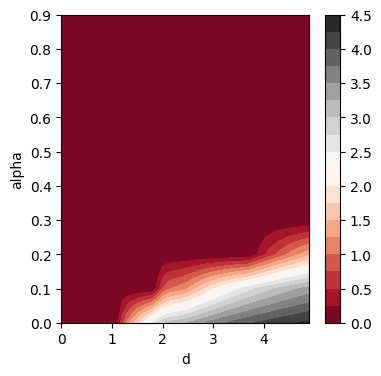

epoch 335 / 500 : loss = 101999.6640625
epoch 336 / 500 : loss = 101999.6015625
epoch 337 / 500 : loss = 101999.5234375
epoch 338 / 500 : loss = 101999.5
epoch 339 / 500 : loss = 101999.4453125


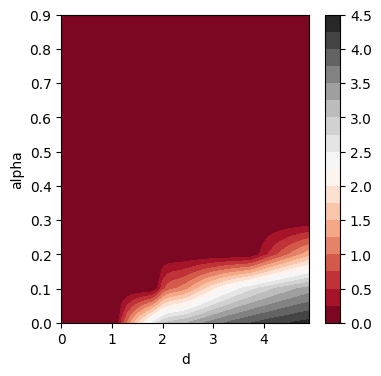

epoch 340 / 500 : loss = 101999.390625
epoch 341 / 500 : loss = 101999.3515625
epoch 342 / 500 : loss = 101999.296875
epoch 343 / 500 : loss = 101999.265625
epoch 344 / 500 : loss = 101999.203125


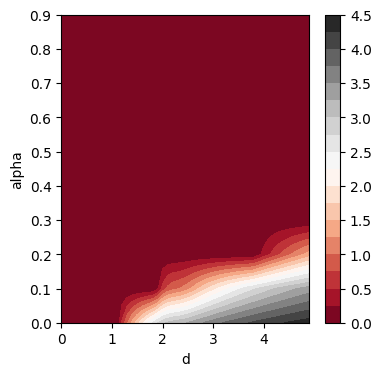

epoch 345 / 500 : loss = 101999.1484375
epoch 346 / 500 : loss = 101999.0859375
epoch 347 / 500 : loss = 101999.0390625
epoch 348 / 500 : loss = 101998.984375
epoch 349 / 500 : loss = 101998.9375


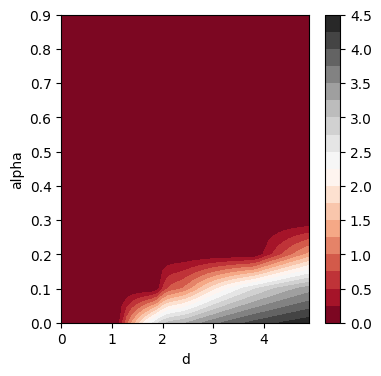

epoch 350 / 500 : loss = 101998.8828125
epoch 351 / 500 : loss = 101998.8203125
epoch 352 / 500 : loss = 101998.7734375
epoch 353 / 500 : loss = 101998.7265625
epoch 354 / 500 : loss = 101998.6796875


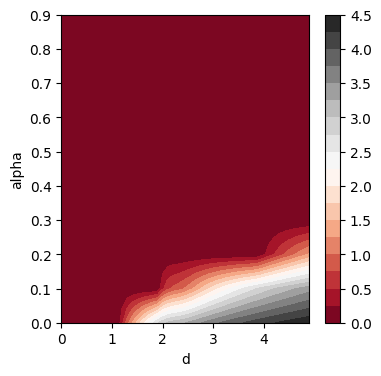

epoch 355 / 500 : loss = 101998.6171875
epoch 356 / 500 : loss = 101998.5625
epoch 357 / 500 : loss = 101998.515625
epoch 358 / 500 : loss = 101998.4609375
epoch 359 / 500 : loss = 101998.4140625


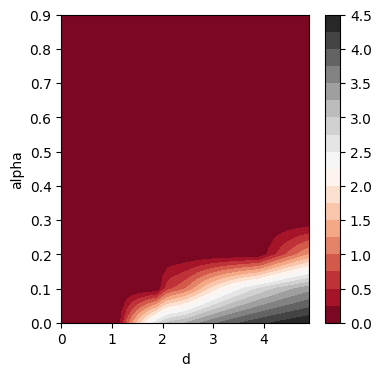

epoch 360 / 500 : loss = 101998.34375
epoch 361 / 500 : loss = 101998.2890625
epoch 362 / 500 : loss = 101998.234375
epoch 363 / 500 : loss = 101998.1796875
epoch 364 / 500 : loss = 101998.1328125


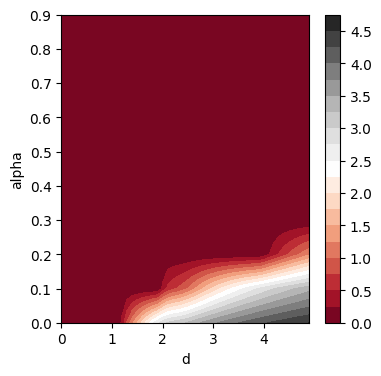

epoch 365 / 500 : loss = 101998.1015625
epoch 366 / 500 : loss = 101998.0703125
epoch 367 / 500 : loss = 101998.015625
epoch 368 / 500 : loss = 101997.984375
epoch 369 / 500 : loss = 101997.9453125


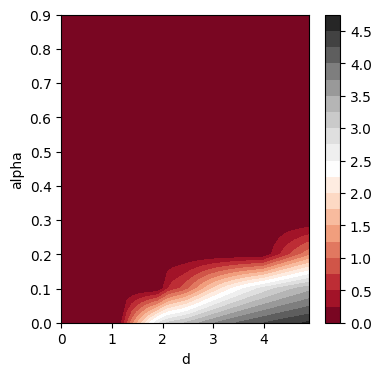

epoch 370 / 500 : loss = 101997.90625
epoch 371 / 500 : loss = 101997.859375
epoch 372 / 500 : loss = 101997.8125
epoch 373 / 500 : loss = 101997.765625
epoch 374 / 500 : loss = 101997.734375


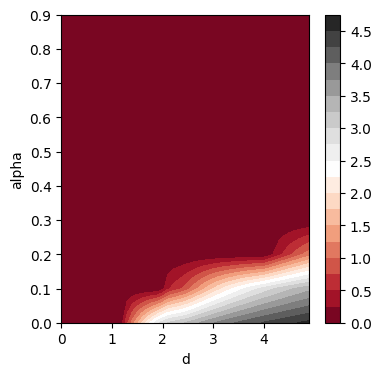

epoch 375 / 500 : loss = 101997.6953125
epoch 376 / 500 : loss = 101997.6328125
epoch 377 / 500 : loss = 101997.6015625
epoch 378 / 500 : loss = 101997.5390625
epoch 379 / 500 : loss = 101997.5390625


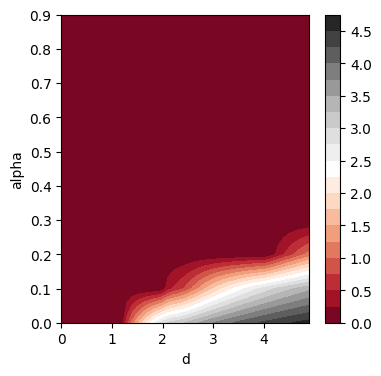

epoch 380 / 500 : loss = 101997.4765625
epoch 381 / 500 : loss = 101997.4296875
epoch 382 / 500 : loss = 101997.3828125
epoch 383 / 500 : loss = 101997.3515625
epoch 384 / 500 : loss = 101997.2890625


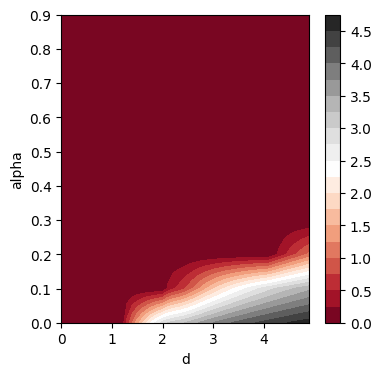

epoch 385 / 500 : loss = 101997.2421875
epoch 386 / 500 : loss = 101997.203125
epoch 387 / 500 : loss = 101997.15625
epoch 388 / 500 : loss = 101997.1015625
epoch 389 / 500 : loss = 101997.0625


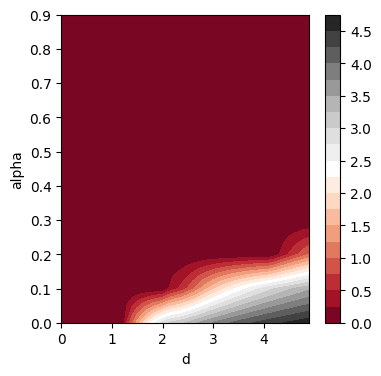

epoch 390 / 500 : loss = 101997.0078125
epoch 391 / 500 : loss = 101996.9609375
epoch 392 / 500 : loss = 101996.90625
epoch 393 / 500 : loss = 101996.8671875
epoch 394 / 500 : loss = 101996.8203125


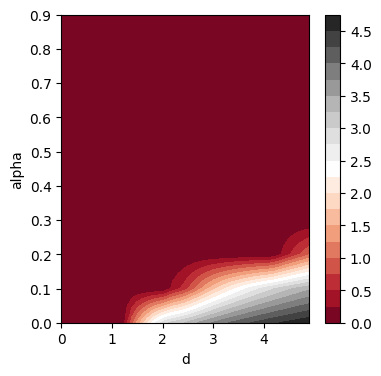

epoch 395 / 500 : loss = 101996.7890625
epoch 396 / 500 : loss = 101996.734375
epoch 397 / 500 : loss = 101996.734375
epoch 398 / 500 : loss = 101996.6875
epoch 399 / 500 : loss = 101996.65625


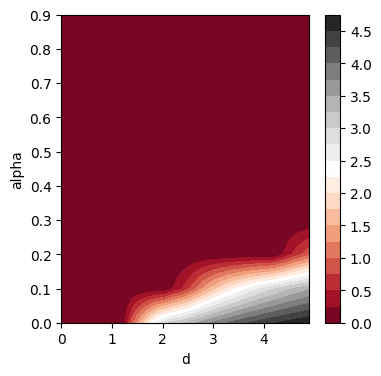

epoch 400 / 500 : loss = 101996.6171875
epoch 401 / 500 : loss = 101996.5859375
epoch 402 / 500 : loss = 101996.5546875
epoch 403 / 500 : loss = 101996.515625
epoch 404 / 500 : loss = 101996.46875


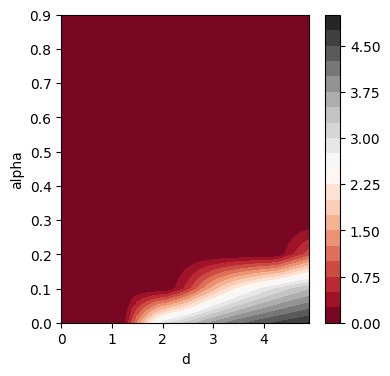

epoch 405 / 500 : loss = 101996.453125
epoch 406 / 500 : loss = 101996.4140625
epoch 407 / 500 : loss = 101996.3515625
epoch 408 / 500 : loss = 101996.34375
epoch 409 / 500 : loss = 101996.296875


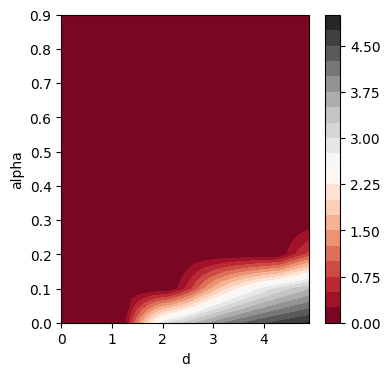

epoch 410 / 500 : loss = 101996.265625
epoch 411 / 500 : loss = 101996.2421875
epoch 412 / 500 : loss = 101996.1953125
epoch 413 / 500 : loss = 101996.15625
epoch 414 / 500 : loss = 101996.1484375


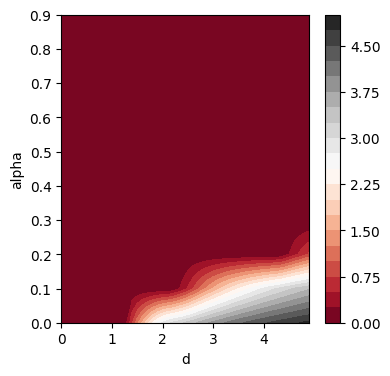

epoch 415 / 500 : loss = 101996.078125
epoch 416 / 500 : loss = 101996.046875
epoch 417 / 500 : loss = 101996.015625
epoch 418 / 500 : loss = 101995.96875
epoch 419 / 500 : loss = 101995.9296875


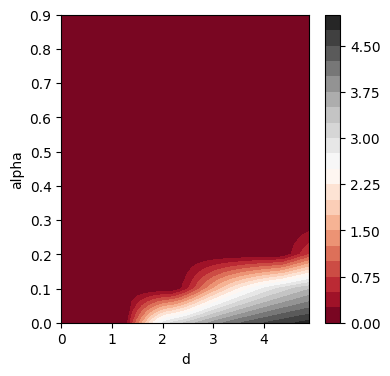

epoch 420 / 500 : loss = 101995.8828125
epoch 421 / 500 : loss = 101995.8671875
epoch 422 / 500 : loss = 101995.8125
epoch 423 / 500 : loss = 101995.7890625
epoch 424 / 500 : loss = 101995.75


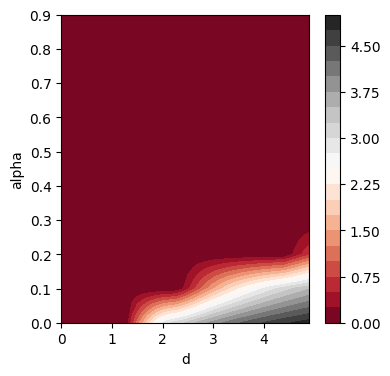

epoch 425 / 500 : loss = 101995.6953125
epoch 426 / 500 : loss = 101995.6640625
epoch 427 / 500 : loss = 101995.6171875
epoch 428 / 500 : loss = 101995.59375
epoch 429 / 500 : loss = 101995.5625


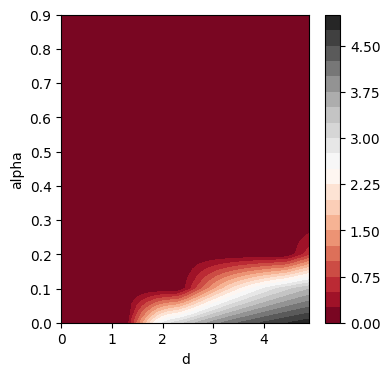

epoch 430 / 500 : loss = 101995.5078125
epoch 431 / 500 : loss = 101995.453125
epoch 432 / 500 : loss = 101995.4453125
epoch 433 / 500 : loss = 101995.40625
epoch 434 / 500 : loss = 101995.3828125


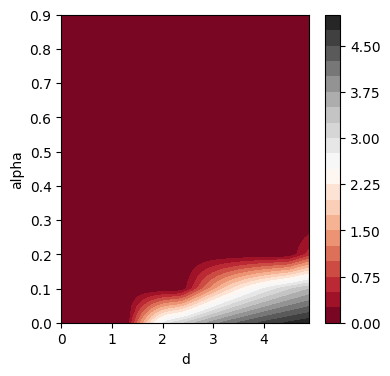

epoch 435 / 500 : loss = 101995.3515625
epoch 436 / 500 : loss = 101995.34375
epoch 437 / 500 : loss = 101995.3046875
epoch 438 / 500 : loss = 101995.28125
epoch 439 / 500 : loss = 101995.2421875


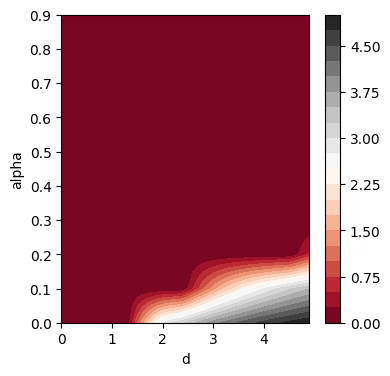

epoch 440 / 500 : loss = 101995.21875
epoch 441 / 500 : loss = 101995.1953125
epoch 442 / 500 : loss = 101995.171875
epoch 443 / 500 : loss = 101995.1484375
epoch 444 / 500 : loss = 101995.109375


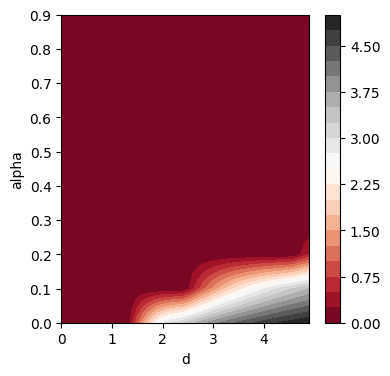

epoch 445 / 500 : loss = 101995.09375
epoch 446 / 500 : loss = 101995.0703125
epoch 447 / 500 : loss = 101995.03125
epoch 448 / 500 : loss = 101994.984375
epoch 449 / 500 : loss = 101994.96875


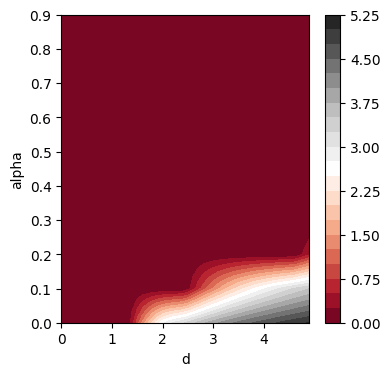

epoch 450 / 500 : loss = 101994.9296875
epoch 451 / 500 : loss = 101994.9140625
epoch 452 / 500 : loss = 101994.8671875
epoch 453 / 500 : loss = 101994.859375
epoch 454 / 500 : loss = 101994.8046875


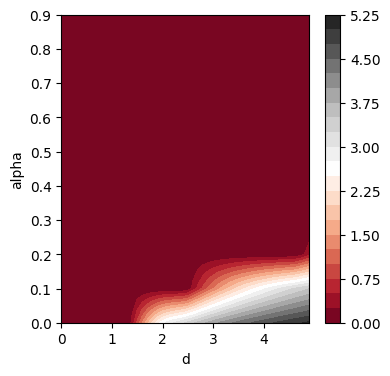

epoch 455 / 500 : loss = 101994.8046875
epoch 456 / 500 : loss = 101994.7578125
epoch 457 / 500 : loss = 101994.7265625
epoch 458 / 500 : loss = 101994.6875
epoch 459 / 500 : loss = 101994.6640625


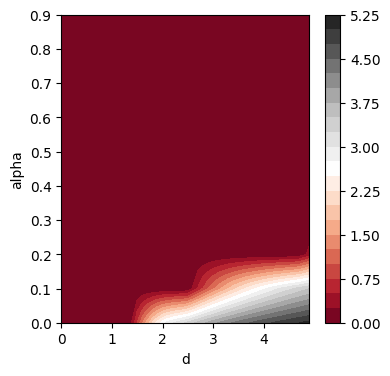

epoch 460 / 500 : loss = 101994.640625
epoch 461 / 500 : loss = 101994.6171875
epoch 462 / 500 : loss = 101994.59375
epoch 463 / 500 : loss = 101994.546875
epoch 464 / 500 : loss = 101994.5234375


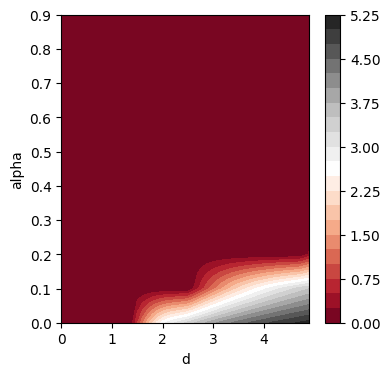

epoch 465 / 500 : loss = 101994.5
epoch 466 / 500 : loss = 101994.453125
epoch 467 / 500 : loss = 101994.421875
epoch 468 / 500 : loss = 101994.390625
epoch 469 / 500 : loss = 101994.359375


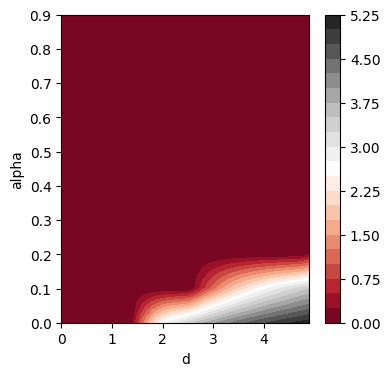

epoch 470 / 500 : loss = 101994.3359375
epoch 471 / 500 : loss = 101994.28125
epoch 472 / 500 : loss = 101994.2734375
epoch 473 / 500 : loss = 101994.2265625
epoch 474 / 500 : loss = 101994.1875


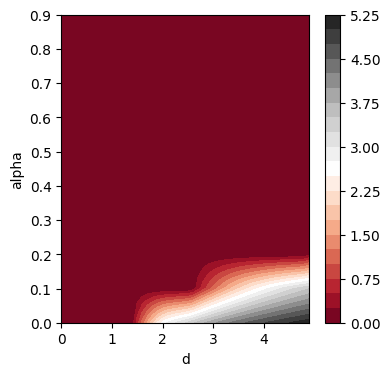

epoch 475 / 500 : loss = 101994.171875
epoch 476 / 500 : loss = 101994.1328125
epoch 477 / 500 : loss = 101994.09375
epoch 478 / 500 : loss = 101994.0703125
epoch 479 / 500 : loss = 101994.0546875


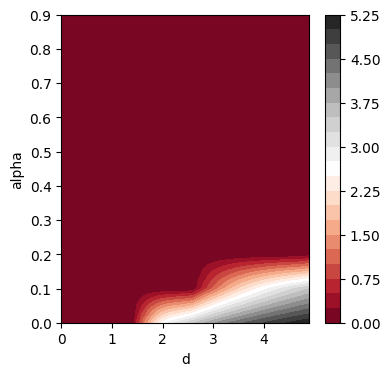

epoch 480 / 500 : loss = 101994.0390625
epoch 481 / 500 : loss = 101994.015625
epoch 482 / 500 : loss = 101994.015625
epoch 483 / 500 : loss = 101993.9921875
epoch 484 / 500 : loss = 101993.9609375


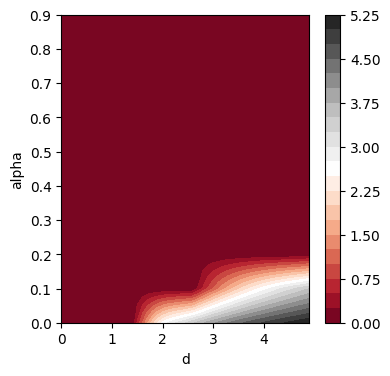

epoch 485 / 500 : loss = 101993.953125
epoch 486 / 500 : loss = 101993.9296875
epoch 487 / 500 : loss = 101993.8984375
epoch 488 / 500 : loss = 101993.875
epoch 489 / 500 : loss = 101993.8671875


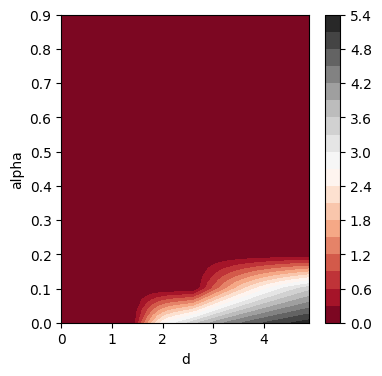

epoch 490 / 500 : loss = 101993.8359375
epoch 491 / 500 : loss = 101993.8046875
epoch 492 / 500 : loss = 101993.796875
epoch 493 / 500 : loss = 101993.7578125
epoch 494 / 500 : loss = 101993.7578125


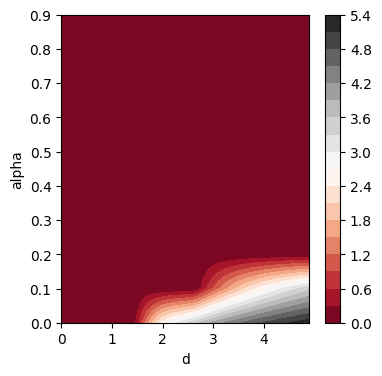

epoch 495 / 500 : loss = 101993.734375
epoch 496 / 500 : loss = 101993.6953125
epoch 497 / 500 : loss = 101993.6953125
epoch 498 / 500 : loss = 101993.65625
epoch 499 / 500 : loss = 101993.625


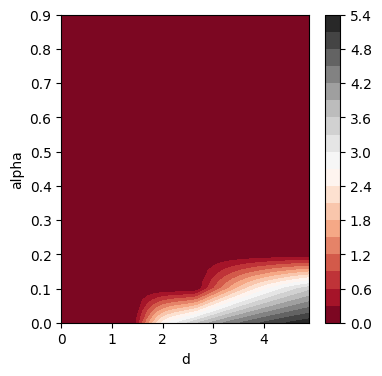

epoch 500 / 500 : loss = 101993.609375


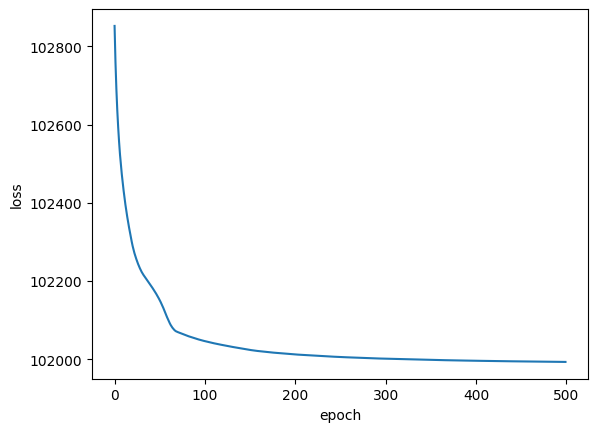

In [13]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-1)

In [14]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


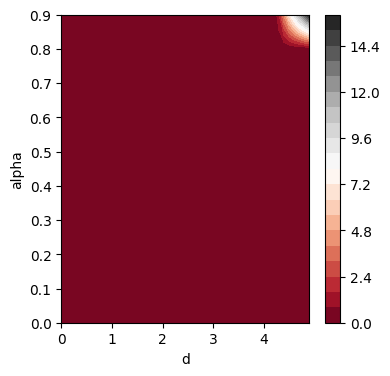

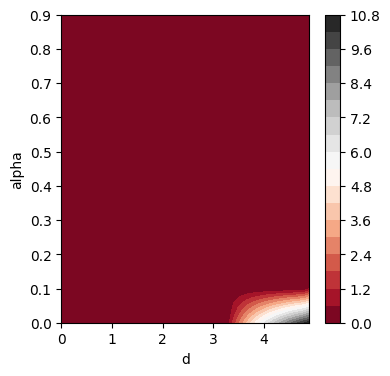

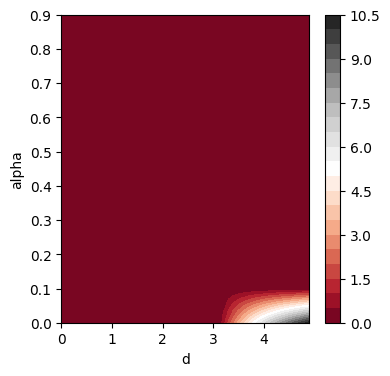

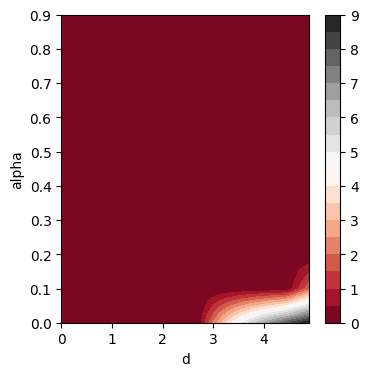

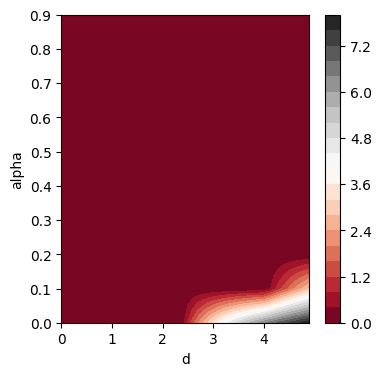

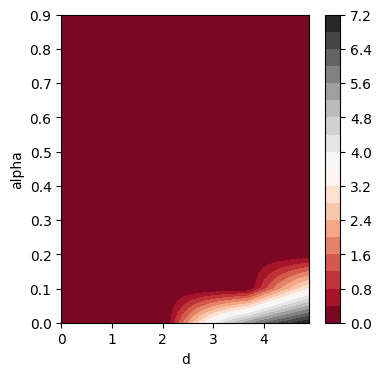

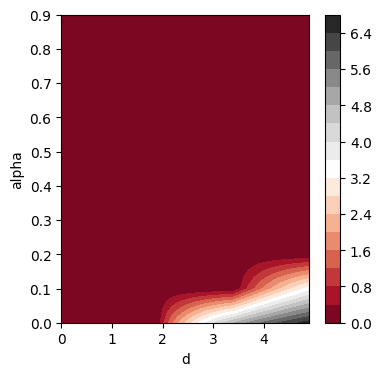

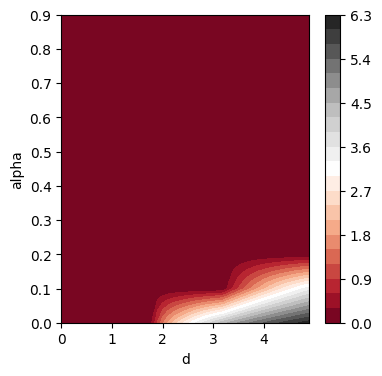

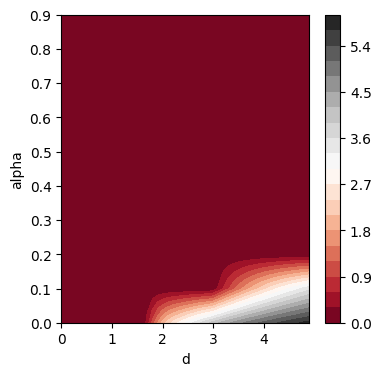

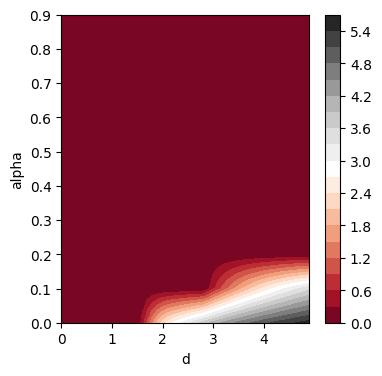

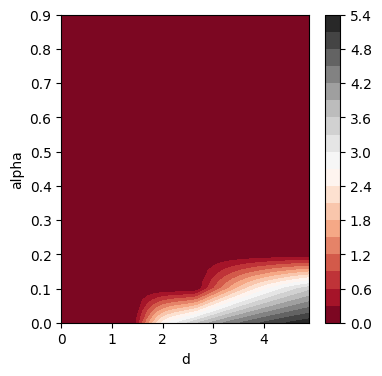

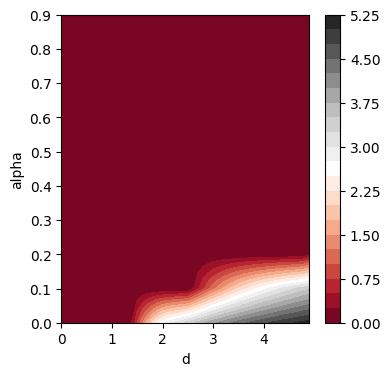

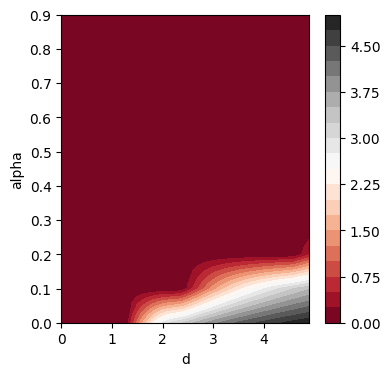

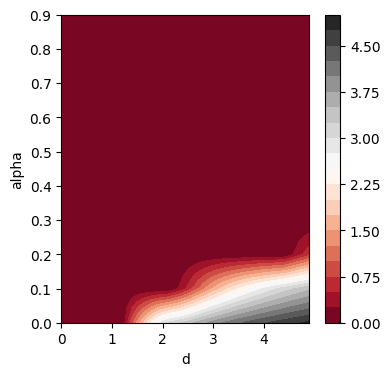

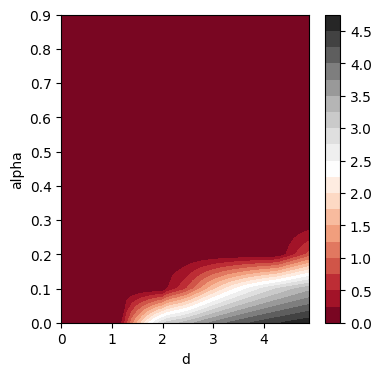

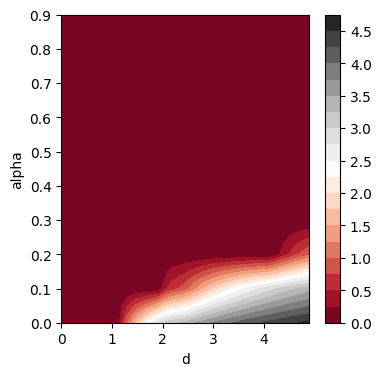

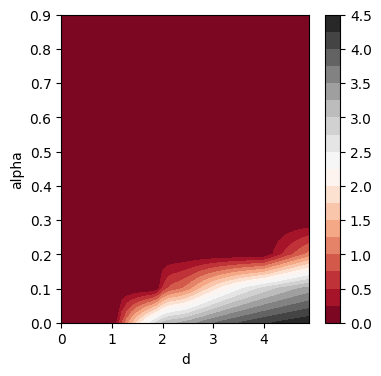

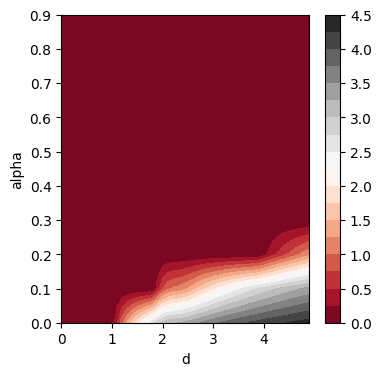

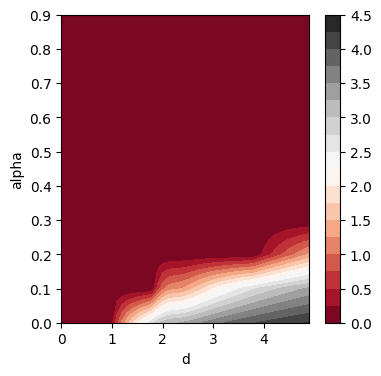

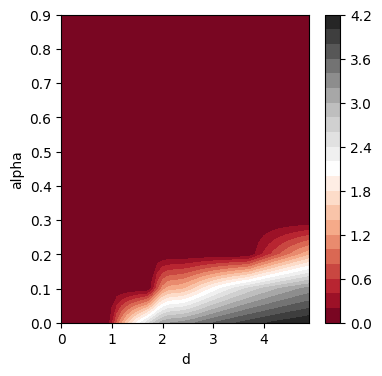

In [15]:
for i in range(0, num_frames, 5):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [16]:
def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = np.zeros((num_frames, len(r_vals)))

    # convert P_alpha_d to numpy array
    P_alpha_d = P_alpha_d.cpu().detach().numpy()
    Z = Z.cpu().detach().numpy()
    alpha_vals = alpha_vals.cpu().detach().numpy()
    d_vals = d_vals.cpu().detach().numpy()

    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
            u_pred[i, j] = np.trapz(integrand, alpha_vals)

    # normalize u_pred
    u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
    # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

    # s_vals = np.linspace(0.0, 2*np.pi, 101)
    s_vals = np.linspace(0.0, 1000, 101)
    s_vals[0] = 1e-10
    s_vals = s_vals[:-1]

    # get the range of k values
    # convert r_vals to numpy array
    r_vals = r_vals.cpu().detach().numpy()
    k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
    # k_vals = 2 * np.pi * k_vals
    # print(k_vals)
    print(f"shape of k_vals : {k_vals.shape}")

    # visualize u_pred
    plt.figure(figsize=(10, 8))
    plt.title("u_pred(s, k) for some s values")
    plt.xlabel("k")
    plt.ylabel("u_pred(s, k)")
    plt.grid()
    for i in range(0, s_vals.shape[0], 10):
        if i == 0:
            continue
        plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

    plt.legend()
    plt.show()

shape of k_vals : (500,)


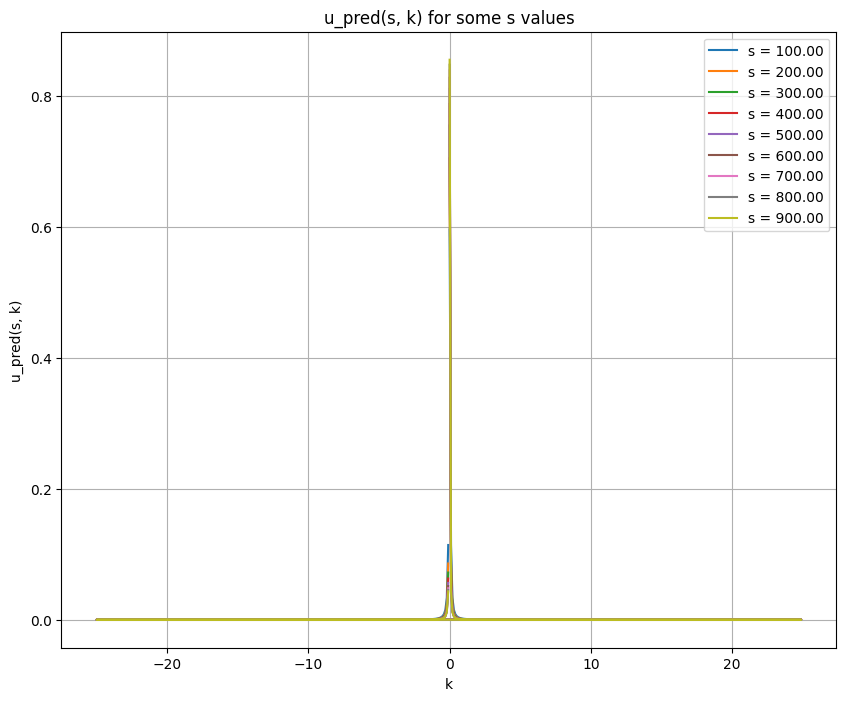

In [17]:
# reproduce u_pred
give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
